In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table

import os

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, colors

import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Circle

from matplotlib.lines import Line2D

import xspec as x

import matplotlib
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec

from scipy import stats
from scipy.optimize import curve_fit

from tqdm.autonotebook import tqdm

/tmp/ipykernel_6183/1558250574.py:28: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
clusters = pd.read_csv("../data/eROSITA_30.0x30.0/Catalouges/cluster.dat", sep='\s+', header=0)
clusters = clusters[clusters["M500"]>1e14]
clusters = clusters[clusters["flag"]==0]
clusters

ihal     x_pix     y_pix     z_pix      Rrel          Mvir    z_true  \
171     110  0.970969  0.479718  0.014316  0.004703  2.432930e+14  0.157249   
187     163  0.388924  0.570999  0.016006  0.004675  2.390080e+14  0.157312   
350      77  0.380183  0.570491  0.033800  0.005197  3.282700e+14  0.157977   
820      68  0.735543  0.863489  0.086085  0.005228  3.341870e+14  0.159935   
1245    111  0.804864  0.355207  0.133510  0.004668  2.379170e+14  0.161713   
...     ...       ...       ...       ...       ...           ...       ...   
18589   113  0.839159  0.495644  0.394607  0.011199  2.242680e+14  0.063945   
18610   199  0.149218  0.307198  0.406194  0.011455  2.400200e+14  0.064342   
19523   349  0.373303  0.943536  0.987909  0.010375  1.783400e+14  0.084342   
19771   323  0.759637  0.387809  0.508332  0.020783  1.912580e+14  0.034099   
19787    83  0.926032  0.822913  0.526959  0.026050  3.766600e+14  0.034717   

          z_obs          M500     R500      Mstar500       Mgas500     T500  \
171    0.157891  1.366960e+14  688.128  4.470500e+12  1.209540e+13  2.44633   
187    0.159659  1.126680e+14  645.187  2.896080e+12  1.061830e+13  2.43074   
350    0.157810  1.925340e+14  771.351  5.156740e+12  2.121000e+13  3.21771   
820    0.160192  1.800240e+14  754.271  6.340420e+12  1.596800e+13  3.57076   
1245   0.161111  1.321030e+14  680.349  4.667490e+12  9.869480e+12  2.78095   
...         ...           ...      ...           ...           ...      ...   
18589  0.063977  1.184480e+14  615.838  2.883010e+12  1.160680e+13  2.22808   
18610  0.064928  1.282700e+14  632.408  3.427130e+12  1.130680e+13  2.26553   
19523  0.084015  1.055570e+14  592.650  3.313370e+12  6.942770e+12  2.39539   
19771  0.033707  1.272360e+14  616.706  3.593030e+12  1.067760e+13  2.61661   
19787  0.033992  1.682650e+14  676.952  5.699780e+12  1.686950e+13  2.84568   

          Lx500    Ysz500          M200      R200  flag  
171    0.707698  0.000003  2.049620e+14  1068.920     0  
187    0.532571  0.000003  2.049290e+14  1068.880     0  
350    1.515690  0.000005  2.887220e+14  1198.270     0  
820    0.972861  0.000004  2.724390e+14  1175.290     0  
1245   0.452088  0.000003  1.944720e+14  1050.360     0  
...         ...       ...           ...       ...   ...  
18589  0.537683  0.000002  1.889120e+14   976.536     0  
18610  0.455429  0.000002  1.935300e+14   984.440     0  
19523  0.231120  0.000002  1.464050e+14   897.005     0  
19771  0.651073  0.000003  1.638830e+14   910.698     0  
19787  0.951228  0.000004  2.866160e+14  1097.250     0  

[84 rows x 18 columns]

In [3]:
wd = "../data/eROSITA_30.0x30.0/Phox/"
mylist = sorted(os.listdir(wd))

phlists = [item for item in mylist if item[:6] == "phlist"]

print(phlists)

phlists_redshifts = [fits.open(wd+item)[0].header["REDSHIFT"] for item in phlists]#[::-1]

print(phlists_redshifts)

['phlist_124.fits', 'phlist_128.fits', 'phlist_132.fits', 'phlist_136.fits', 'phlist_140.fits']
[0.174192889973847, 0.13708140389145, 0.101142861718869, 0.0663401914452304, 0.032637492755919]


In [4]:
geometry = pd.read_csv("../data/eROSITA_30.0x30.0/Catalouges/geometry.dat", sep='\s+', header=2)
geometry

snapNr      ztab    zslice   z_start     z_end          x0          y0  \
0     144  0.001001  0.008625  0.000000  0.017281  230.604600   52.929941   
1     140  0.033671  0.033822  0.017281  0.050478  305.341400  149.855590   
2     136  0.067408  0.067555  0.050478  0.084760   97.871486  134.586170   
3     132  0.102245  0.102388  0.084760  0.120158  185.353850  229.067940   
4     128  0.138220  0.138357  0.120158  0.156713  146.337120  179.784950   
5     124  0.175368  0.175501  0.156713  0.194460  170.716390  187.570430   

           z0       depth       width  
0   38.137176   73.327162   21.167728  
1  172.109480  139.387980   82.573299  
2  117.805860  141.855220  163.761220  
3  294.134880  144.222380  246.344710  
4  264.241690  146.478010  330.262680  
5  175.891600  148.610980  415.447530

In [5]:
binned_clusters = {}
   
for borders in list(zip(geometry["z_start"], geometry["z_end"], geometry["zslice"], geometry["snapNr"])):
    
    for ind in clusters.index:

        zt = clusters.loc[ind]["z_true"]

        if zt > borders[0] and zt < borders[1]:

            binned_clusters[ind] = borders[2], str(borders[3])
                
#sorted(binned_clusters.items())

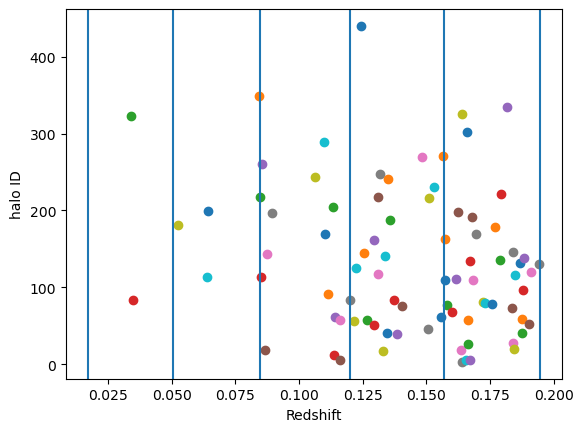

In [6]:
for cl_num in clusters.index[:]:
    #print(i, cl_num, clusters["z_true"][cl_num])
    plt.scatter(clusters["z_true"][cl_num], clusters["ihal"][cl_num])
    
for j in geometry["z_end"]:
    plt.axvline(j)
    
plt.xlabel("Redshift")
plt.ylabel("halo ID")
plt.show()

## (A) Single cluster

In [72]:
#display(clusters[clusters["ihal"]==231])
display(clusters[clusters.index==6740])

ihal    x_pix    y_pix     z_pix      Rrel          Mvir   z_true  \
6740   116  0.52248  0.00266  0.742646  0.004547  2.199160e+14  0.18468   

         z_obs          M500     R500      Mstar500       Mgas500     T500  \
6740  0.186161  1.221290e+14  662.766  3.378200e+12  1.305640e+13  2.19175   

         Lx500    Ysz500          M200     R200  flag  
6740  0.758763  0.000003  1.864240e+14  1035.69     0

https://cxc.cfa.harvard.edu/ciao/ahelp/dmstat.html

<Figure size 640x480 with 0 Axes>

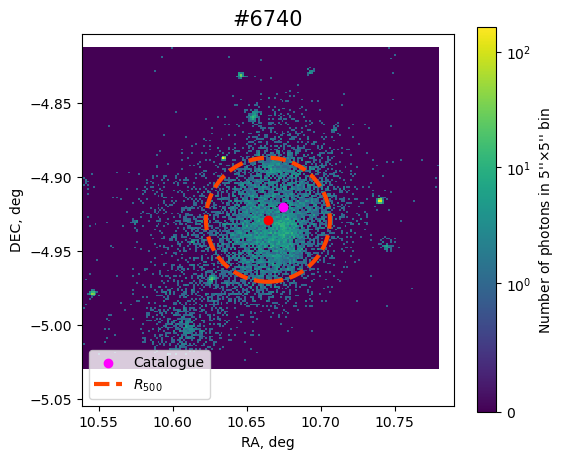

In [70]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6,5))

cl_num = 6740

pho_list = extract_photons_from_cluster(cl_num, r = 'R500', center_is_peak=True, draw=True)

#display(pho_list)

#plt.savefig("figures/cl_r500.pdf", format="pdf")
plt.show()

<Figure size 640x480 with 0 Axes>

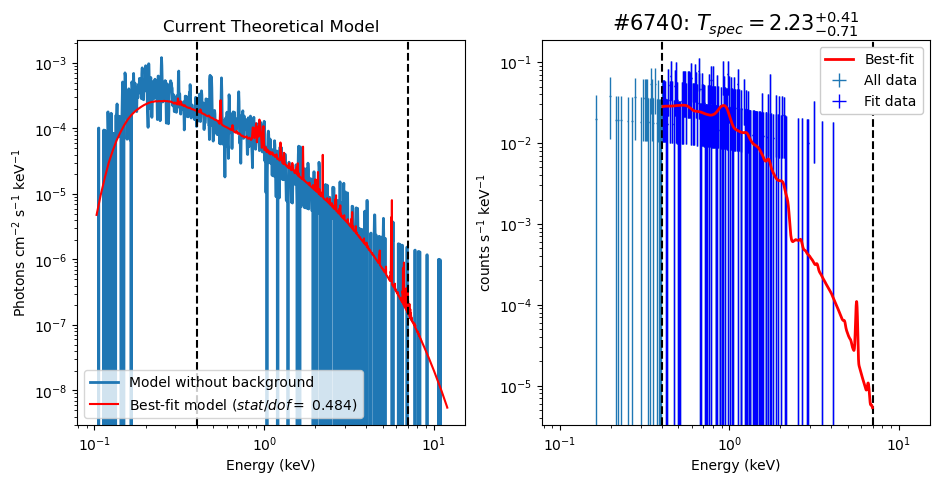


1 file 1 spectrum 
Spectrum 1  Spectral Data File: fakeit.pha
Net count rate (cts/s) for Spectrum:1  2.610e-02 +/- 1.616e-03
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  58-722
  Telescope: eROSITA Instrument: TM1  Channel Type: PI
  Exposure Time: 1e+04 sec
 Using fit statistic: cstat
 Using Response (RMF) File            ../erosita/erosita_pirmf_v20210719.rmf for Source 1
 Using Auxiliary Response (ARF) File  ../erosita/tm1_arf_open_000101v02.fits



In [75]:
%run -i 'utils/scripts.py'

#logFile = x.Xset.openLog("newLogFile.txt")

#create_spectrum_old(pho_list, REDSHIFT=clusters.loc[cl_num]["z_true"]) # or binned_clusters[19787][0] ???

plt.figure(figsize=(11, 5))

SP = create_spectrum_and_fit_it(cl_num, borders=[0.4, 7.0], BACKGROUND=False, inside_radius="R500",
                                Xplot=False, plot=True, draw_only=False)

#plt.axvline(0.7, ls=':', color='g')
plt.show()

#print(SP)
x.AllData.show()

##### The use of the $\chi^2$ statistic for evaluating the goodness of fit. 

The data here are a series of observations of the luminosity of a star, with known error bars. Our model assumes that the brightness of the star does not vary; that is, all the scatter in the data is due to measurement error. $\chi^2_{\rm dof} \approx 1$ indicates that the model fits the data well (upper-left panel). $\chi^2_{\rm dof}$ much smaller than 1 (upper-right panel) is an indication that the errors are overestimated. $\chi^2_{\rm dof}$ much larger than 1 is an indication either that the errors are underestimated (lower-left panel) or that the model is not a good description of the data (lower-right panel). In this last case, it is clear from the data that the star’s luminosity is varying with time: this situation is be treated more fully in chapter 10. [Source](https://www.astroml.org/book_figures/chapter4/fig_chi2_eval.html)

[Kaastra (2017): On the use of C-stat in testing models for X-ray spectra](https://www.aanda.org/articles/aa/pdf/2017/09/aa29319-16.pdf)

[Dos and don’ts of reduced chi-squared](https://arxiv.org/pdf/1012.3754.pdf)

## (B)  Draw all 84 clusters

<Figure size 640x480 with 0 Axes>

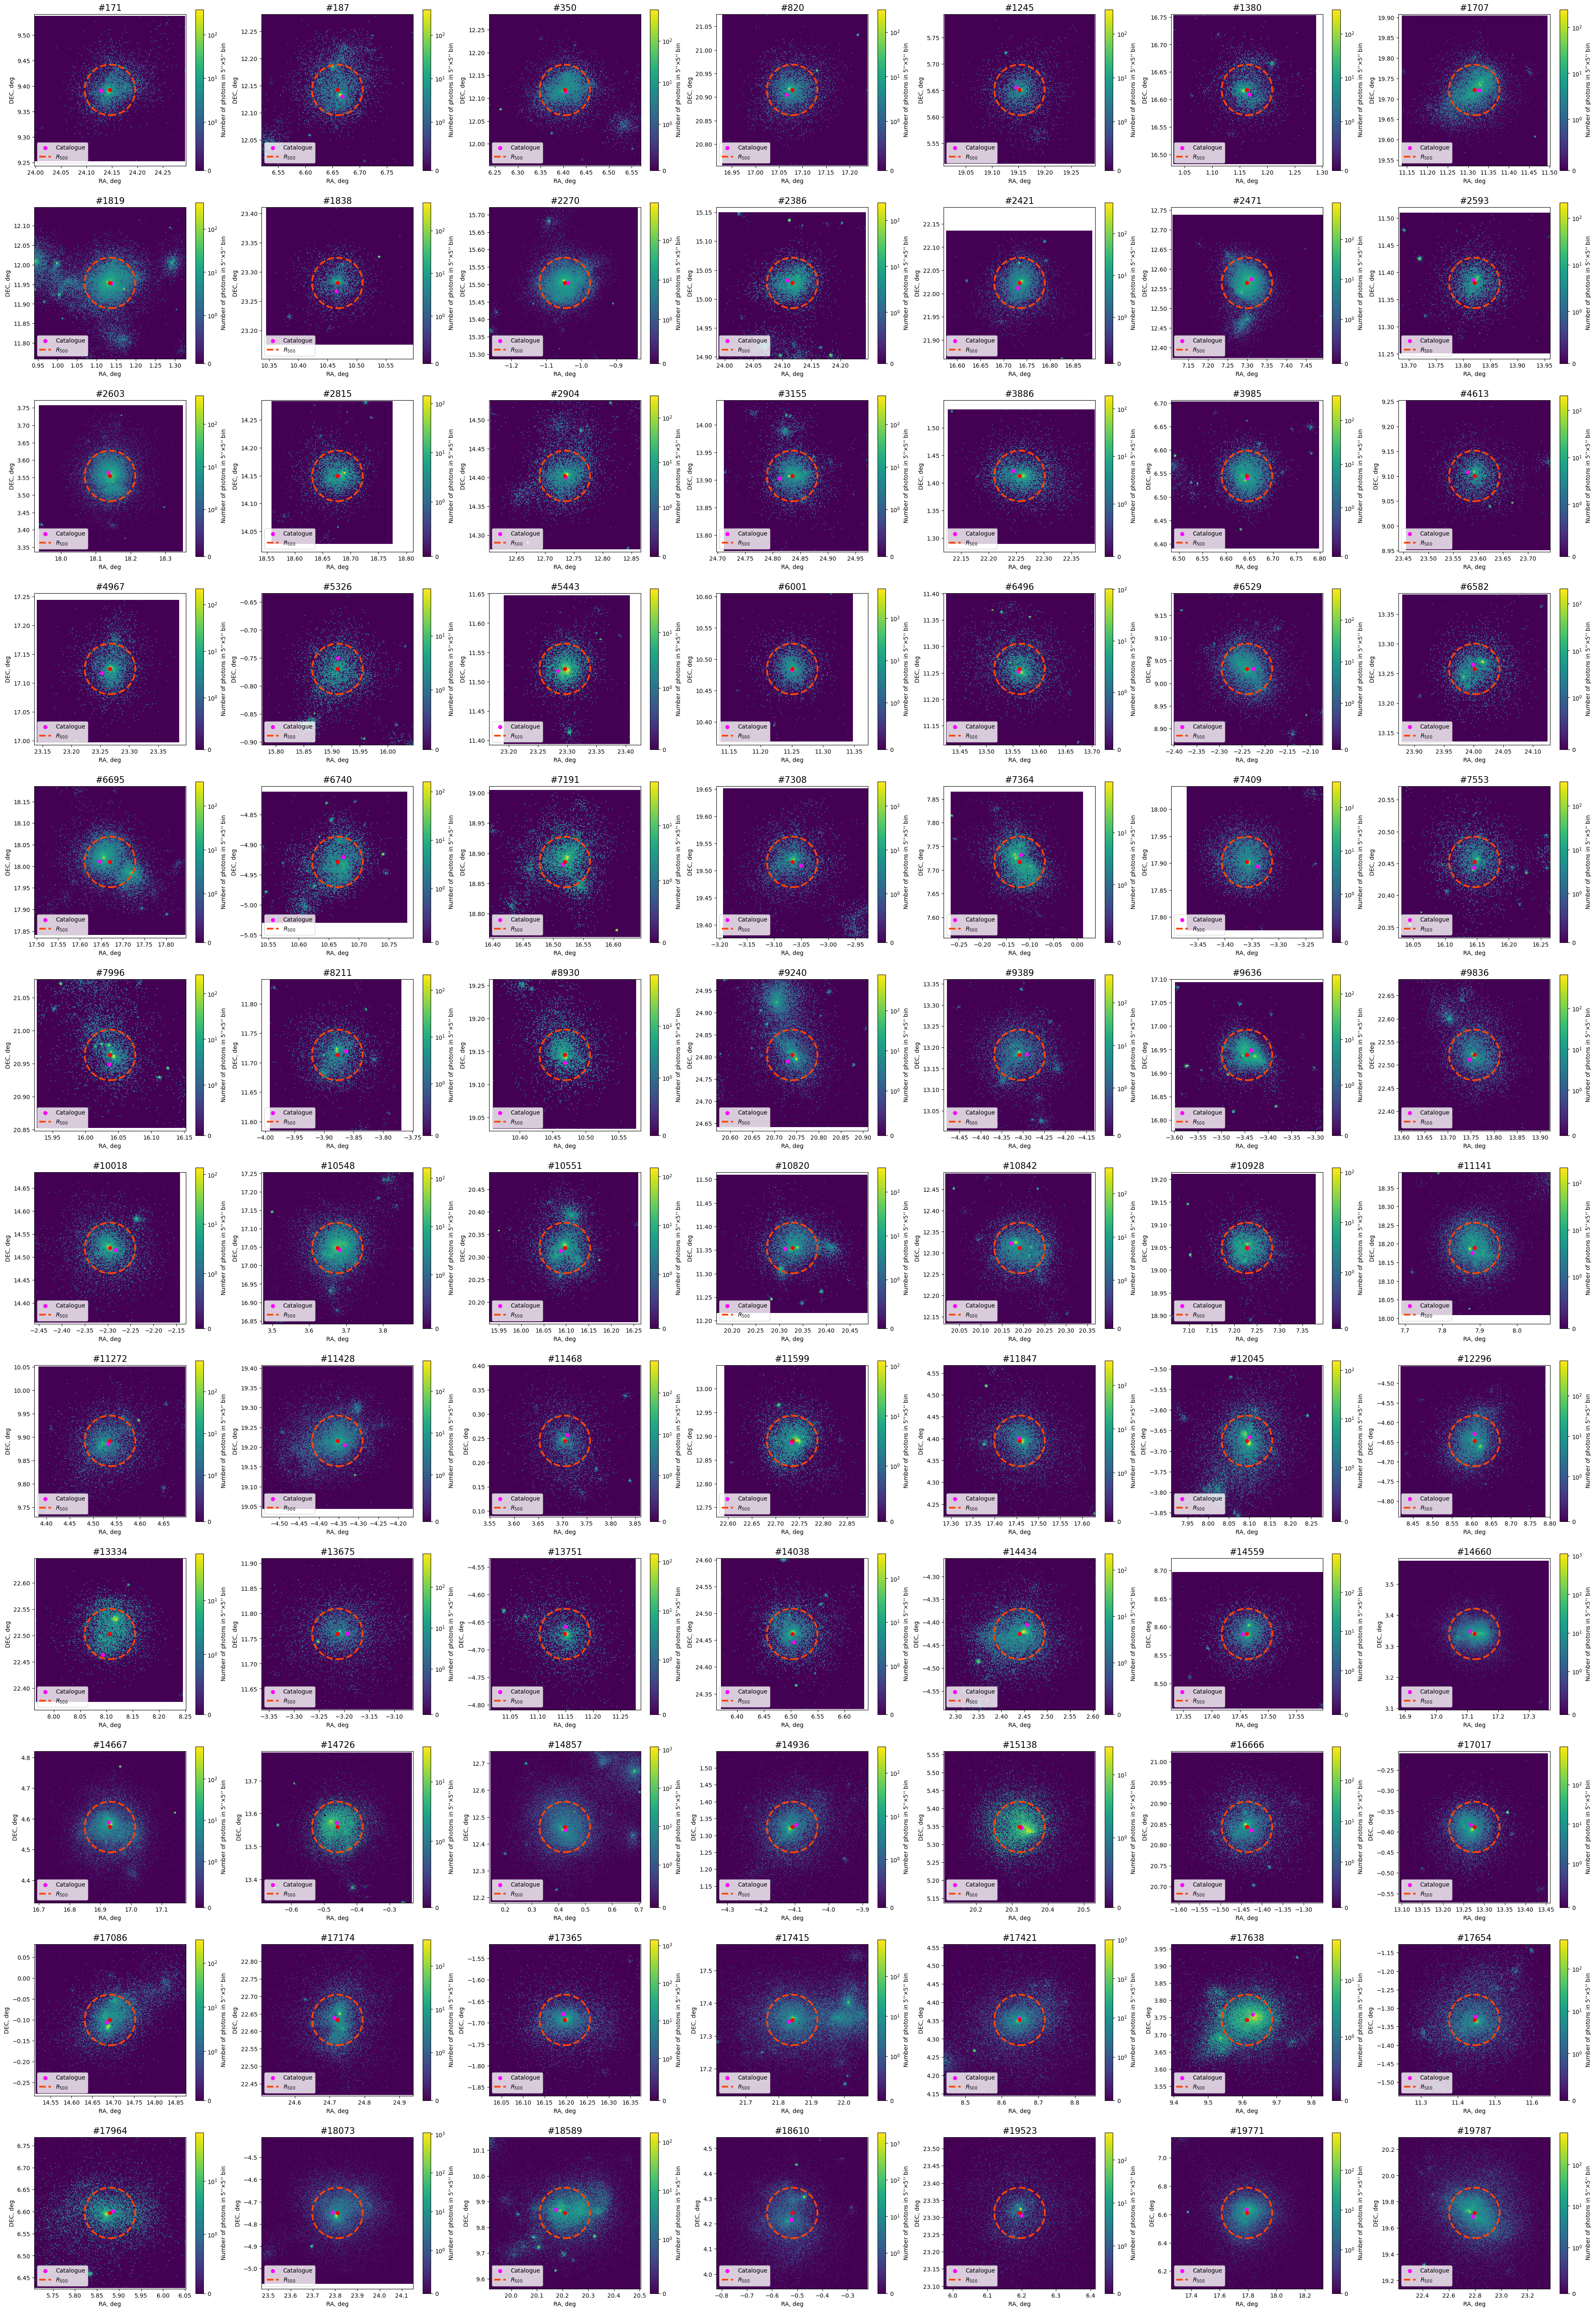

In [69]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

draw_84_panels(mode='IMAGE')
    
plt.show()

In [76]:
from xspec_table_models import XspecTableModelAdditive

https://github.com/mbursa/xspec-table-models

In [ ]:
radii = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5]  # in units of projected R_500


for cl_num in clusters.index[:2]:
    
    for radius in radii:
        
        pho_list = extract_photons_from_cluster(cl_num, r = radius, draw=False)

        N_channels1 = 1024
        binning1 = np.logspace(np.log10(0.1), np.log10(12.0), N_channels1+1)
        photons1, energies_bins1 = np.histogram(pho_list["ENERGY"], bins = binning1)
        energies1 = [(a+b)/2 for a, b in zip(energies_bins1[:-1], energies_bins1[1:])]
        dE1 = np.diff(energies_bins1)

        atablemodel_input = [a*b*(1.6*10**(-9))/10000/1000/c for a, b, c in zip(photons, energies, dE1)]




        par1 = ('Number', [current_cluster_num], False, False)
        par2 = ('Radius', radii, False, False)

        feets = XspecTableModelAdditive('a_table.fits', 'myAtableModel', np.array(energies1), [par1, par2])
        
        # [erg/s/cm2/keV]

        fits11.write(0, atablemodel_input, False) 
        fits11.save()

## (B0)  Fit  and draw all 84 clusters' spectra, with or without background

#### Considering: abundance = 0.3, cstat, exposure = 10000 s, weights = standard 

In [ ]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

draw_84_panels(mode='DATA')

plt.show()

In [69]:
#temp_compare, lumin_compare

## (B1)  Draw all 84 clusters' models (original and fitted), with or without background

In [ ]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

draw_84_panels(mode='MODEL')

plt.show()

### (B2) Temperature and luminosity from fit as a functions of $T_{500}$ and $L_{500}$ from simulations for single fit.

In [ ]:
NNN = 84

temp_compare = {}
lumin_compare = {}
average_ene = {}

for cl_num in clusters.index[:NNN]:

    cl_T500 = clusters.loc[cl_num]["T500"]
    cl_lum = clusters.loc[cl_num]["Lx500"]

    SP = create_spectrum_and_fit_it(cl_num, 
                                    borders=[0.4, 7.0], 
                                    BACKGROUND=False, 
                                    inside_radius="R500",
                                    Xplot=False, 
                                    plot=False, 
                                    draw_only=False, 
                                    draw_and_save_atable_model=False)

    temp_compare[cl_num] = [cl_T500, SP[0][:3]]
    lumin_compare[cl_num] = [cl_lum, SP[1][:3]]
    average_ene[cl_num] = [SP[2]]

[Solution](https://stackoverflow.com/questions/10208814/colormap-for-errorbars-in-x-y-scatter-plot) for plot.

In [ ]:
masses = [clusters.loc[i]["M500"]/10**14 for i in clusters.index]
norm = matplotlib.colors.Normalize(vmin=min(masses), vmax=max(masses), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap='viridis')
mass_colour = np.array([(mapper.to_rgba(v)) for v in masses])

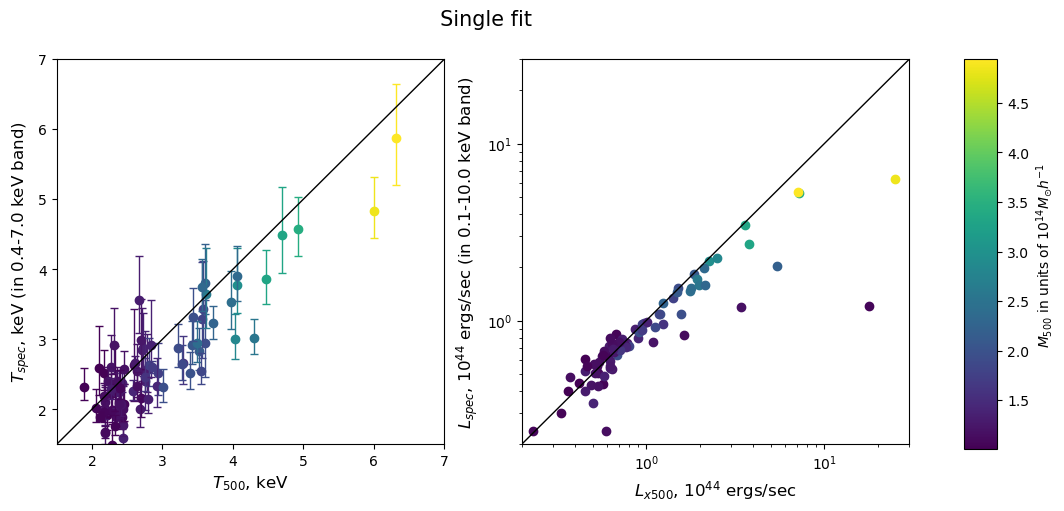

In [23]:
plt.figure(figsize=(11,5))

plt.suptitle("     Single fit", fontsize=15)

plt.subplot(121)

xx = [a[0] for a in temp_compare.values()]
yy = [a[1][0] for a in temp_compare.values()]
yll = [a[1][1] for a in temp_compare.values()]
yrr = [a[1][2] for a in temp_compare.values()]
yerr_l = [a-b for a, b in zip(yy, yll)]
yerr_r = [a-b for a, b in zip(yrr, yy)]

#plt.errorbar(xx, yy, yerr=[yerr_l, yerr_r], linewidth=0, elinewidth=1, color='b', marker='o', markersize=3)

for xxx, yyy, e1, e2, col in zip(xx, yy, yerr_l, yerr_r, mass_colour):
    plt.plot(xxx, yyy, 'o', color=col)
    plt.errorbar(xxx, yyy, yerr=[[e1], [e2]], elinewidth=1, capsize=3, color=col)

plt.xlabel("$T_{500}$, keV", fontsize=12)
plt.ylabel("$T_{spec}$, keV (in 0.4-7.0 keV band)", fontsize=12)

plt.xlim(1.5, 7.0)
plt.ylim(1.5, 7.0)

plt.plot([min(plt.gca().get_xlim()), max(plt.gca().get_xlim())],
         [min(plt.gca().get_ylim()), max(plt.gca().get_ylim())], color='black', linewidth=1)

plt.subplot(122)

xx = [a[0] for a in lumin_compare.values()]
yy = [a[1][0] for a in lumin_compare.values()]
yll = [a[1][1] for a in lumin_compare.values()]
yrr = [a[1][2] for a in lumin_compare.values()]
yerr_l = [a-b for a, b in zip(yy, yll)]
yerr_r = [a-b for a, b in zip(yrr, yy)]

#plt.errorbar(xx, yy, yerr=[yerr_l, yerr_r], linewidth=0, elinewidth=1, color='b', marker='o', markersize=3)

for xxx, yyy, e1, e2, col in zip(xx, yy, yerr_l, yerr_r, mass_colour):
    plt.plot(xxx, yyy, 'o', color=col)
    plt.errorbar(xxx, yyy, yerr=[[e1], [e2]], elinewidth=1, capsize=3, color=col)

plt.xlabel("$L_{x500}$, $10^{44}$ ergs/sec", fontsize=12)
plt.ylabel("$L_{spec}$, $10^{44}$ ergs/sec (in 0.1-10.0 keV band)", fontsize=12)

plt.xscale("log")
plt.yscale("log")

plt.xlim(0.2, 30)
plt.ylim(0.2, 30)

plt.plot([min(plt.gca().get_xlim()), max(plt.gca().get_xlim())],
         [min(plt.gca().get_ylim()), max(plt.gca().get_ylim())], color='black', linewidth=1)

plt.subplots_adjust(right=0.9)
sc = plt.scatter(xx, yy, c=masses, s=5)
clb = plt.colorbar(sc, cax = plt.axes([0.95, 0.1, 0.03, 0.78]), 
                   label = "$M_{500}$ in units of $10^{14} M_{\odot} h^{-1}$")

plt.show()

#### There are no errors for luminosity (xspec somehow doesn't calculate them)

### (B3) Average energy as a function of temperature for single fit

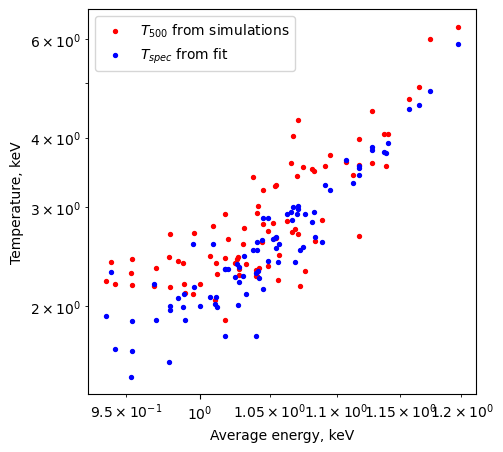

In [24]:
plt.figure(figsize=(5,5))

xg = average_ene.values()
yg0 = [a[0] for a in temp_compare.values()]
yg1 = [a[1][0] for a in temp_compare.values()]
plt.scatter(xg, yg0, c='red', s=8, label='$T_{500}$ from simulations')
plt.scatter(xg, yg1, c='blue', s=8, label='$T_{spec}$ from fit')

plt.xlabel("Average energy, keV")
plt.ylabel("Temperature, keV")

plt.xscale("log")
plt.yscale("log")

#plt.colorbar(label = "$M_{500}$ in units of $10^{14} M_{\odot} h^{-1}$")
plt.legend()

plt.show()

## (C) Averaging

##### Check that abundance is FIXED (at 0.3 Solar) here:

In [ ]:
%run -i 'utils/scripts.py'

NNNN = 10

calculate_all_and_average_it(NNNN, bkg=False, write_to_file='0_ab-fix_cstat_10ks_standard-'+str(NNNN)+'_redshifted')

#### Reading from table:

In [7]:
NNNN = 50

table_name = '0_ab-fix_cstat_10ks_standard-'+str(NNNN)#+'_redshifted'

read_table = pd.read_csv('tables/table_'+table_name+'.csv', header=None, index_col=0, delimiter=' ').to_dict()
    
temp_usr =  list(zip(read_table[1].values(), read_table[2].values(), read_table[3].values()))
lumin_usr = list(zip(read_table[4].values(), read_table[5].values(), read_table[6].values()))
aven_usr =  list(zip(read_table[7].values(), read_table[8].values()))

### (C0) Spectral temperature compared with $T_{500}$

In [8]:
redshifts = [clusters.loc[i]["z_true"] for i in clusters.index]
norm_red = matplotlib.colors.Normalize(vmin=min(redshifts), vmax=max(redshifts), clip=True)
mapper_red = cm.ScalarMappable(norm=norm_red, cmap='rainbow')
redshifts_colour = np.array([(mapper_red.to_rgba(v)) for v in redshifts])

<Figure size 640x480 with 0 Axes>

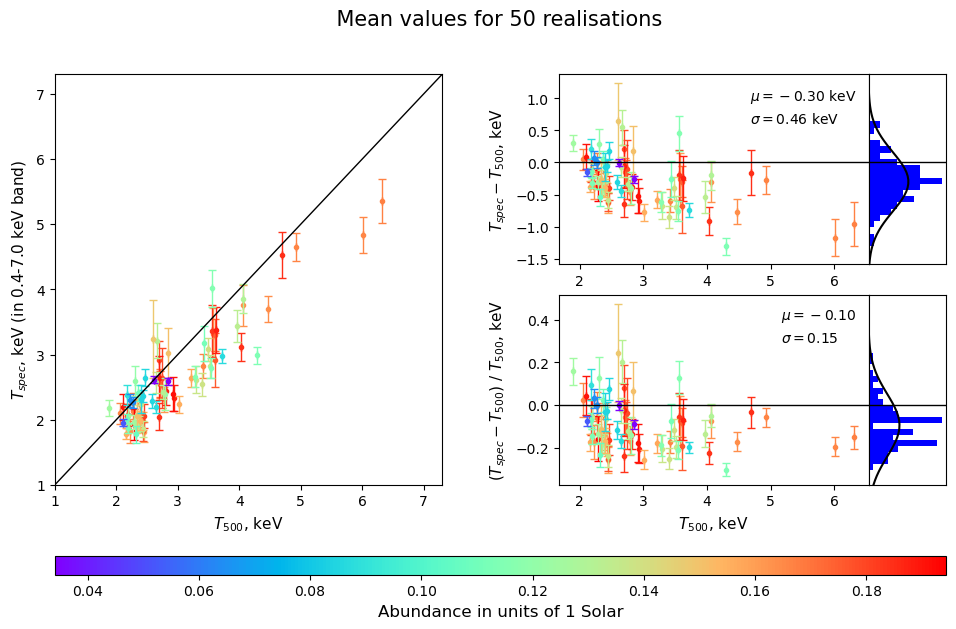

In [9]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

rtrt = list(zip(np.zeros(len(temp_usr)), [a[0] for a in temp_usr], np.zeros(len(temp_usr))))

draw_three_panels(x_array=rtrt,
                  y_array=temp_usr,
                  x_label="$T_{500}$, keV",
                  y_label_left="$T_{spec}$, keV (in 0.4-7.0 keV band)",
                  y_label_right_up="$T_{spec} - T_{500}$, keV",
                  y_label_right_down="$(T_{spec} - T_{500}) \ / \ T_{500}$, keV",
                  clr='b',
                  NnNn=NNNN,
                  cmap=redshifts)

#plt.savefig('figures/T_vs_T500.pdf', format='pdf')
plt.show()

### (C1) Temperature and luminosity from fit as a functions of $T_{500}$ and $L_{500}$ from several fits.

In [ ]:
masses = [clusters.loc[i]["M500"]/10**14 for i in clusters.index]
norm = matplotlib.colors.Normalize(vmin=min(masses), vmax=max(masses), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap='viridis')
mass_colour = np.array([(mapper.to_rgba(v)) for v in masses])

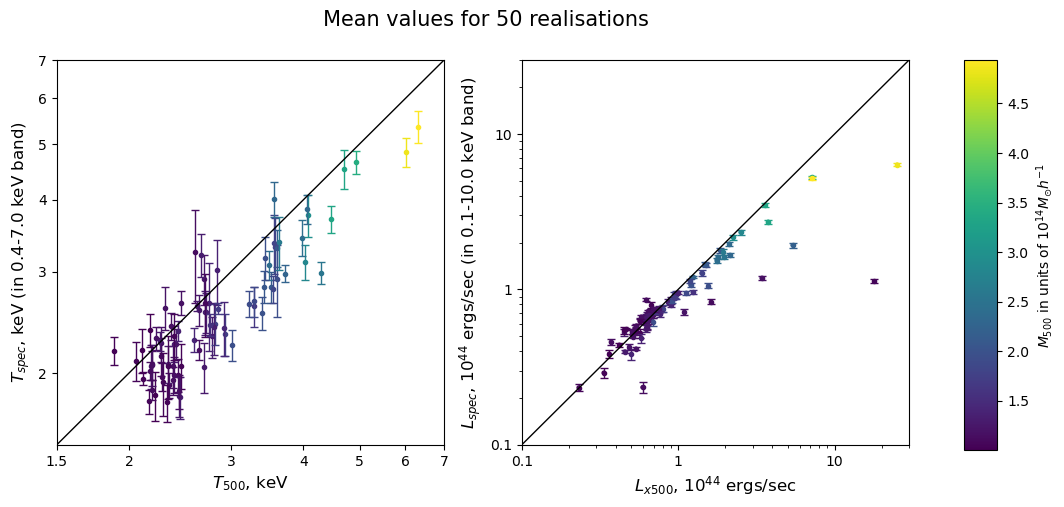

In [41]:
plt.figure(figsize=(11,5))

plt.suptitle(f"     Mean values for {NNNN} realisations", fontsize=15)

plt.subplot(121)

xx = [a[0] for a in temp_usr]
yy = [a[1] for a in temp_usr]
y_err = [a[2] for a in temp_usr]

#plt.errorbar(xx, yy, yerr=[yerr_l, yerr_r], linewidth=0, elinewidth=1, color='b', marker='o', markersize=3)

for xxx, yyy, eee, col in zip(xx, yy, y_err, mass_colour):
    plt.plot(xxx, yyy, '.', color=col)
    plt.errorbar(xxx, yyy, yerr=eee, elinewidth=1, capsize=3, color=col)

plt.xlabel("$T_{500}$, keV", fontsize=12)
plt.ylabel("$T_{spec}$, keV (in 0.4-7.0 keV band)", fontsize=12)

plt.xlim(1.5, 7)
plt.ylim(1.5, 7)

plt.xscale("log")
plt.yscale("log")

plt.xticks([plt.gca().get_xlim()[0],2,3,4,5,6,7], [plt.gca().get_xlim()[0],2,3,4,5,6,7])
plt.yticks([2,3,4,5,6,7], [2,3,4,5,6,7])

plt.plot([min(plt.gca().get_xlim()), max(plt.gca().get_xlim())],
         [min(plt.gca().get_ylim()), max(plt.gca().get_ylim())], color='black', linewidth=1)

#plt.scatter(2.60178, 3.985203132730008, color='red')

plt.subplot(122)

xx = [a[0] for a in lumin_usr]
yy = [a[1] for a in lumin_usr]
y_err = [a[2] for a in lumin_usr]

#plt.errorbar(xx, yy, yerr=[yerr_l, yerr_r], linewidth=0, elinewidth=1, color='b', marker='o', markersize=3)

for xxx, yyy, eee, col in zip(xx, yy, y_err, mass_colour):
    plt.plot(xxx, yyy, '.', color=col)
    plt.errorbar(xxx, yyy, yerr=eee, elinewidth=1, capsize=3, color=col)

plt.xlabel("$L_{x500}$, $10^{44}$ ergs/sec", fontsize=12)
plt.ylabel("$L_{spec}$, $10^{44}$ ergs/sec (in 0.1-10.0 keV band)", fontsize=12)

plt.xscale("log")
plt.yscale("log")

plt.xlim(0.15, 30)
plt.ylim(0.15, 30)

plt.xticks([0.1, 1, 10], [0.1, 1, 10])
plt.yticks([0.1, 1, 10], [0.1, 1, 10])

#plt.axvline(0.592084)
#plt.axhline(0.2546419982104965)

plt.plot([min(plt.gca().get_xlim()), max(plt.gca().get_xlim())],
         [min(plt.gca().get_ylim()), max(plt.gca().get_ylim())], color='black', linewidth=1)

plt.subplots_adjust(right=0.9)
sc = plt.scatter(xx, yy, c=masses, s=5)
clb = plt.colorbar(sc, cax = plt.axes([0.95, 0.1, 0.03, 0.78]), 
                   label = "$M_{500}$ in units of $10^{14} M_{\odot} h^{-1}$")

plt.savefig('figures/T_vs_T_and_L_vs_L.pdf', format='pdf')

plt.show()

#L-T, L-M, T-M

#### Note how small are errors for luminosities!

### (C2) Average energy as a function of **mean** temperature

##### aven_usr: [ $E_{av}, \Delta E$ ], temp_usr: [ $T_{sim}, T_{spec}, \Delta T$ ]

[How to get confidence intervals from curve_fit](https://stackoverflow.com/questions/39434402/how-to-get-confidence-intervals-from-curve-fit)

[Correct fitting with scipy curve_fit including errors in x?](https://stackoverflow.com/questions/26058792/correct-fitting-with-scipy-curve-fit-including-errors-in-x)

[How to plot 1-Sigma Prediction Interval for scipy.odr](https://stackoverflow.com/questions/60889680/how-to-plot-1-sigma-prediction-interval-for-scipy-odr)

[Confidence interval for exponential curve fit](https://stackoverflow.com/questions/24633664/confidence-interval-for-exponential-curve-fit/37080916#37080916)

0.7976190476190477 0.20238095238095238 84


<Figure size 640x480 with 0 Axes>

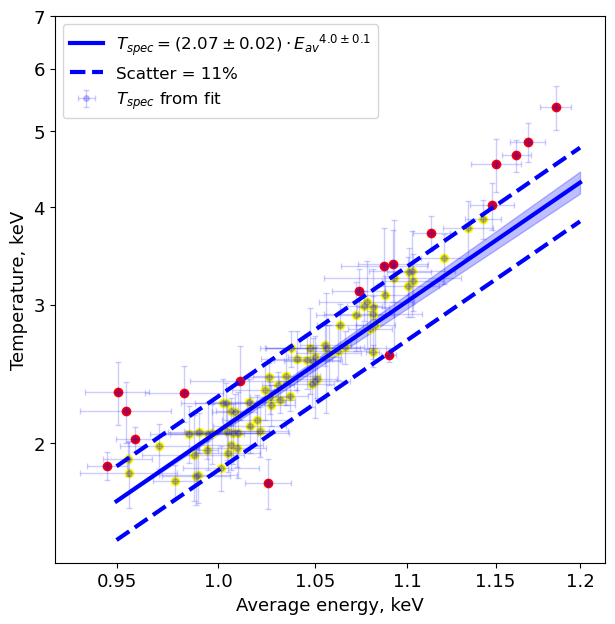

In [111]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

plt.figure(figsize=(7.1,7.1))

xx = [a[0] for a in aven_usr]
x_err = [a[1] for a in aven_usr]
yy1 = [a[0] for a in temp_usr]
yy2 = [a[1] for a in temp_usr]
y2_err = [a[2] for a in temp_usr]

def func(x, a, b):
    return a * x**b

lll = np.linspace(0.95, 1.2, 100)        

#draw_line(xx, x_err, yy1, y_es=np.array(yy1)*0, 
#          clr = 'black', 
#          l4dots = '$T_{500}$ from simulations', 
#          l4legend = 'T_{{500}}', 
#          with_scatter=False)        
        
draw_line(xx, x_err, yy2, y_es=y2_err, 
          clr = 'blue', 
          l4dots = '$T_{spec}$ from fit', 
          l4legend = 'T_{{spec}}',
          with_scatter=True,
          u4et_oshibok=True)

plt.xlabel("Average energy, keV", fontsize=13)
plt.ylabel("Temperature, keV", fontsize=13)

plt.xscale("log")
plt.yscale("log")

#plt.ylim(1.4, 9)
#plt.xlim(0.9, 1.35)

plt.xticks([0.95, 1.00, 1.05, 1.10, 1.15, 1.2], [0.95, 1.00, 1.05, 1.10, 1.15, 1.2], size=13)
plt.yticks([2,3,4,5,6,7], [2,3,4,5,6,7], size=13)

#for i in range(0, len(aven_usr)):
#    plt.plot([xx[i]+0.000454, xx[i]+0.000454], 
#             [yy1[i], yy2[i]], 
#             color='grey', alpha=0.4, marker='o', markersize=4)

#plt.grid()

plt.legend(loc=2, fontsize = 12)

ooofff = (plt.gca().get_xlim(), plt.gca().get_ylim())

#plt.title("Energy of photons are multiplied by $(1+z_{cluster})$")
#plt.title("Abundance is free")

#plt.savefig('figures/T_vs_Eav.pdf', format='pdf')
plt.show()

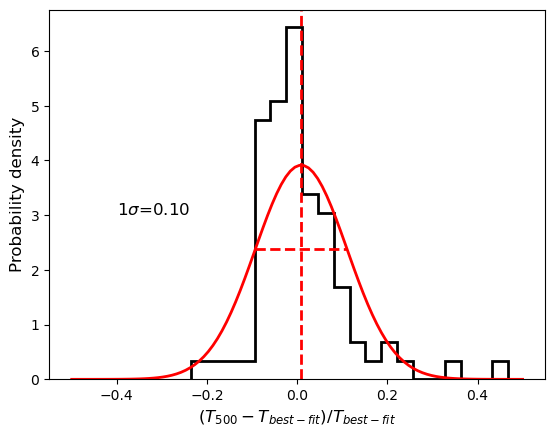

In [56]:
calculate_scatter(xx, yy2, plot=True)

## (D) Impact of abundance fixation

#### Be sure to check that abundance is FREE here:

In [ ]:
%run -i 'utils/scripts.py'

NNNN=10

calculate_all_and_average_it(NNNN, write_to_file='1_ab-free_cstat_10ks_standard'+'_colorbar_abund')

#### Reading from table:

In [46]:
table_name = '1_ab-free_cstat_10ks_standard'#+'_colorbar_abund'

read_table = pd.read_csv('tables/table_'+table_name+'.csv', header=None, index_col=0, delimiter=' ').to_dict()
    
temp_usr_free_abundance =  list(zip(read_table[1].values(), read_table[2].values(), read_table[3].values()))
lumin_usr_free_abundance = list(zip(read_table[4].values(), read_table[5].values(), read_table[6].values()))
aven_usr_free_abundance =  list(zip(read_table[7].values(), read_table[8].values()))

In [24]:
abund_usr_free_abundance = list(zip(read_table[9].values(), read_table[10].values()))

In [25]:
abundances = [a[0] for a in abund_usr_free_abundance]

In [26]:
norm_abund = matplotlib.colors.Normalize(vmin=min(abundances), vmax=max(abundances), clip=True)
mapper_abund = cm.ScalarMappable(norm=norm_abund, cmap='jet_r')
abund_colour = np.array([(mapper_abund.to_rgba(v)) for v in abundances])

<Figure size 640x480 with 0 Axes>

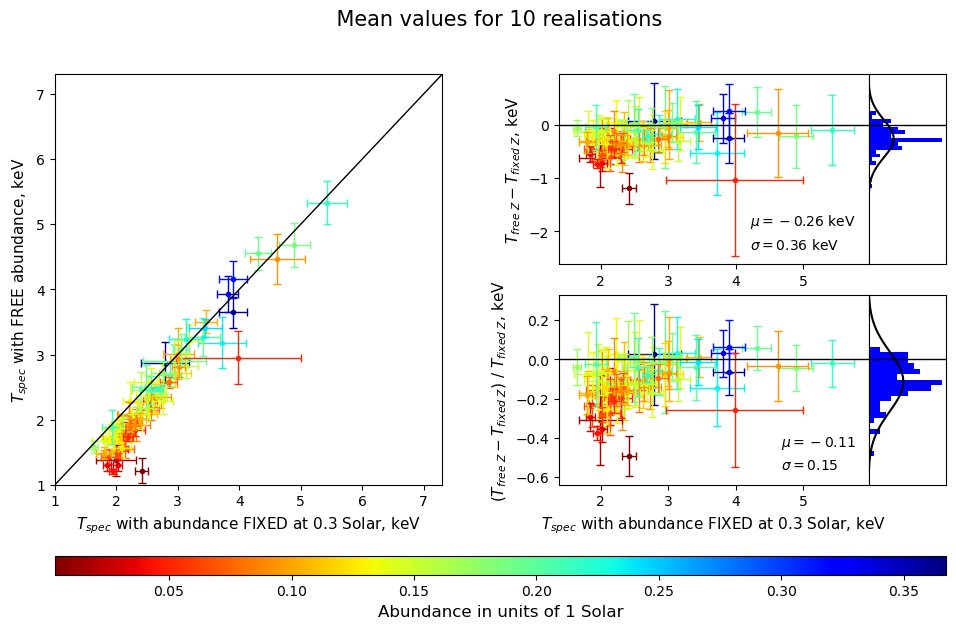

In [27]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

draw_three_panels(x_array=temp_usr, 
                  y_array=temp_usr_free_abundance,
                  x_label="$T_{spec}$ with abundance FIXED at 0.3 Solar, keV",
                  y_label_left="$T_{spec}$ with FREE abundance, keV",
                  y_label_right_up="$T_{free \ Z} - T_{fixed \ Z}$, keV",
                  y_label_right_down="$(T_{free \ Z} - T_{fixed \ Z}) \ / \ T_{fixed \ Z}$, keV",
                  clr='b',
                  NnNn = NNNN,
                  cmap_by_redshifts=True)

## (E) Impact of exposure time with FIXED abundance

##### Previously it was set to 10 ks, now it is changed to 2 ks (check it)

In [ ]:
%run -i 'utils/scripts.py'

NNNN=10

calculate_all_and_average_it(NNNN, write_to_file='2_ab-fix_cstat_02ks_standard')

#### Reading from table:

In [96]:
table_name = '2_ab-fix_cstat_02ks_standard'

read_table = pd.read_csv('tables/table_'+table_name+'.csv', header=None, index_col=0, delimiter=' ').to_dict()
    
temp_usr_smaller_exposure_2ks =  list(zip(read_table[1].values(), read_table[2].values(), read_table[3].values()))
lumin_usr_smaller_exposure_2ks = list(zip(read_table[4].values(), read_table[5].values(), read_table[6].values()))
aven_usr_smaller_exposure_2ks =  list(zip(read_table[7].values(), read_table[8].values()))

<Figure size 640x480 with 0 Axes>

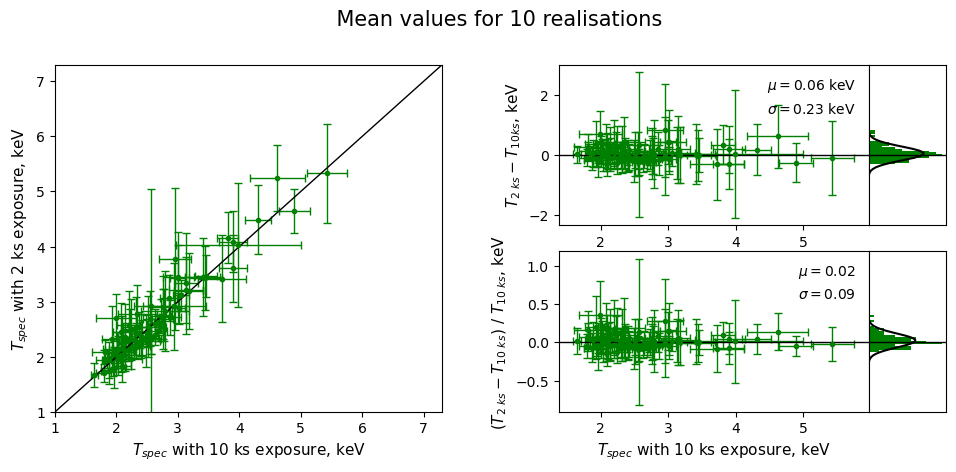

In [97]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

draw_three_panels(x_array=temp_usr, 
                  y_array=temp_usr_smaller_exposure_2ks,
                  x_label="$T_{spec}$ with 10 ks exposure, keV",
                  y_label_left="$T_{spec}$ with 2 ks exposure, keV",
                  y_label_right_up="$T_{2 \ ks} - T_{10 ks}$, keV",
                  y_label_right_down="$(T_{2 \ ks} - T_{10 \ ks}) \ / \ T_{10 \ ks}$, keV",
                  clr='g',
                  NnNn = NNNN)

#### CHECKED: almost no difference for 5 ks. (was relevant for R_vir)

## (E) Impact of statistics with FIXED abundance and 10 ks exposure

#### Previously it was `cstat`, now it is $\chi^2$ (check it)

In [ ]:
%run -i 'utils/scripts.py'

NNNN=10

calculate_all_and_average_it(NNNN, write_to_file='3_ab-fix_chisq_10ks_standard')

#### Reading from table:

In [98]:
table_name = '3_ab-fix_chisq_10ks_standard'

read_table = pd.read_csv('tables/table_'+table_name+'.csv', header=None, index_col=0, delimiter=' ').to_dict()
    
temp_usr_chisq =  list(zip(read_table[1].values(), read_table[2].values(), read_table[3].values()))
lumin_usr_chisq = list(zip(read_table[4].values(), read_table[5].values(), read_table[6].values()))
aven_usr_chisq =  list(zip(read_table[7].values(), read_table[8].values()))

<Figure size 640x480 with 0 Axes>

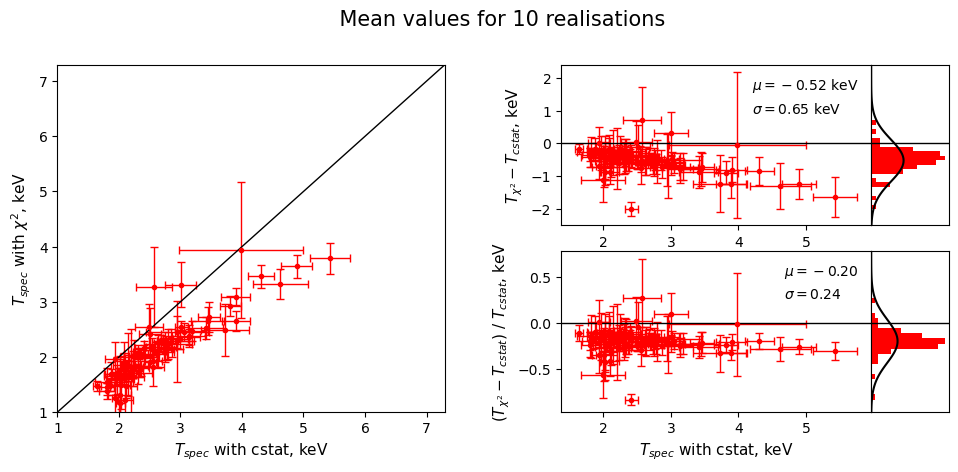

In [99]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

draw_three_panels(x_array=temp_usr, 
                  y_array=temp_usr_chisq,
                  x_label="$T_{spec}$ with cstat, keV",
                  y_label_left="$T_{spec}$ with $\chi^2$, keV",
                  y_label_right_up="$T_{\chi^2} - T_{cstat}$, keV",
                  y_label_right_down="$(T_{\chi^2} - T_{cstat}) \ / \ T_{cstat}$, keV",
                  clr='r',
                  NnNn = NNNN)

## (F) Impact of weights with FIXED abundance, 10 ks exposure and `cstat`

#### Previously it was `standard`, now it is `churazov` (check it)

In [ ]:
%run -i 'utils/scripts.py'

NNNN=10

calculate_all_and_average_it(NNNN, write_to_file='4_ab-fix_cstat_10ks_churazov')

#### Reading from table:

In [120]:
table_name = '4_ab-fix_cstat_10ks_churazov'

read_table = pd.read_csv('tables/table_'+table_name+'.csv', header=None, index_col=0, delimiter=' ').to_dict()
    
temp_usr_churazov =  list(zip(read_table[1].values(), read_table[2].values(), read_table[3].values()))
lumin_usr_churazov = list(zip(read_table[4].values(), read_table[5].values(), read_table[6].values()))
aven_usr_churazov =  list(zip(read_table[7].values(), read_table[8].values()))

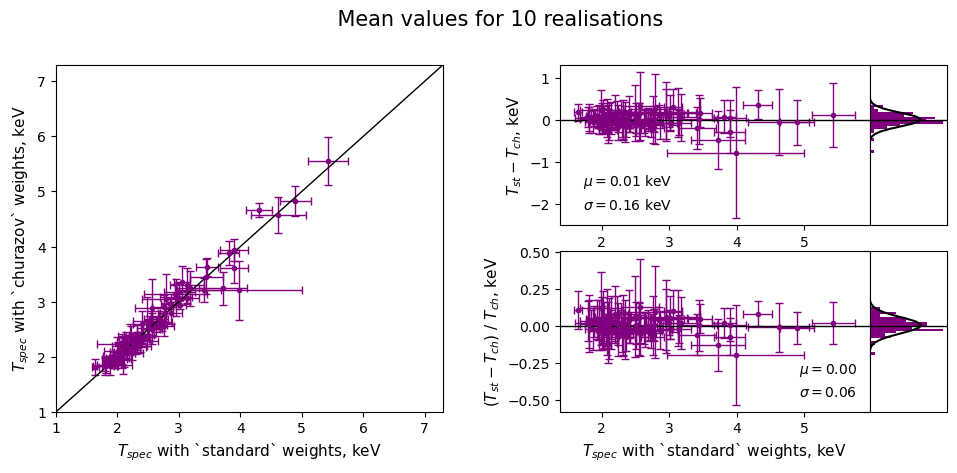

In [121]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

draw_three_panels(x_array=temp_usr, 
                  y_array=temp_usr_churazov,
                  x_label="$T_{spec}$ with `standard` weights, keV",
                  y_label_left="$T_{spec}$ with `churazov` weights, keV",
                  y_label_right_up="$T_{st} - T_{ch}$, keV",
                  y_label_right_down="$(T_{st} - T_{ch}) \ / \ T_{ch}$, keV",
                  clr='purple',
                  NnNn = NNNN)

These 4 plots were at first plotted for $R_{vir}$, then for $R_{500}$ (there was a mistake for the second time: it was also for $R_{vir}$). Now (third time) it is for $R_{500}$.

## (G) Adding background

[ABSOLUTE MEASUREMENT OF THE UNRESOLVED COSMIC X-RAY BACKGROUND
IN THE 0.5–8 KEV BAND WITH CHANDRA](https://arxiv.org/pdf/astro-ph/0512542.pdf)

[CHANDRA SPECTRA OF THE SOFT X-RAY DIFFUSE BACKGROUND](https://iopscience.iop.org/article/10.1086/345347/pdf)

In [ ]:
%run -i 'utils/scripts.py'

NNNN = 9

calculate_all_and_average_it(NNNN, bkg=True, write_to_file='5_ab-fix_cstat_10ks_standard_BKG-'+str(NNNN)+'_with_area')

#### Reading from table:

In [112]:
NNNN = 50

table_name = '5_ab-fix_cstat_10ks_standard_BKG-'+str(NNNN)#+'_with_area'

read_table = pd.read_csv('tables/table_'+table_name+'.csv', header=None, index_col=0, delimiter=' ').to_dict()
    
temp_usr_with_bkg =  list(zip(read_table[1].values(), read_table[2].values(), read_table[3].values()))
lumin_usr_with_bkg = list(zip(read_table[4].values(), read_table[5].values(), read_table[6].values()))
aven_usr_with_bkg =  list(zip(read_table[7].values(), read_table[8].values()))

#### Experiments with constant before background:

In [17]:
area_usr_with_bkg = list(zip(read_table[9].values(), read_table[10].values(), read_table[11].values()))

In [18]:
ORIGA = np.array([n[0] for n in area_usr_with_bkg])
SPECA = np.array([n[1] for n in area_usr_with_bkg])
SKOLKO = SPECA/ORIGA
print(SKOLKO)

[3.14687989 3.36883862 3.66973101 1.66463968 2.87922322 3.20571206
 0.99114031 2.89690947 3.06354593 2.65799938 2.05911384 3.36194672
 2.33379245 1.75512596 1.87657443 2.38978326 2.3825275  2.68907182
 2.32694487 1.87056211 1.63973765 3.14892499 1.49918398 1.79247037
 3.03991336 1.81220698 3.34551471 2.96256398 1.75003981 2.30623093
 2.41492566 2.96230523 2.52860769 2.95750331 1.93758811 3.65236923
 2.25689459 1.96107699 5.2066272  1.88208264 3.22305494 2.02965906
 2.27280543 1.41501187 2.00156805 3.15700232 3.18518569 1.28764656
 1.10220947 1.98171338 1.96752198 2.39258073 3.24975284 1.89961811
 2.56977218 2.61581246 1.24694844 1.61172813 1.74797096 2.82946913
 2.43970653 5.44675548 3.45973729 2.84176842 1.61827608 2.35619538
 3.42066228 1.73422885 2.11739292 3.30790693 5.04930141 1.24343555
 6.62620159 3.33287041 2.02176244 1.1585666  2.44662014 1.5558311
 3.8913896  1.90889292 1.95031019 3.27253645 1.88735556 1.44319693]


In [19]:
norm_area = matplotlib.colors.LogNorm(vmin=min(SKOLKO), vmax=max(SKOLKO), clip=True)
mapper_area = cm.ScalarMappable(norm=norm_area, cmap='jet_r')
area_colour = np.array([(mapper_area.to_rgba(v)) for v in SKOLKO])

In [42]:
int(np.linspace(10, 100, 4))

TypeError: only size-1 arrays can be converted to Python scalars

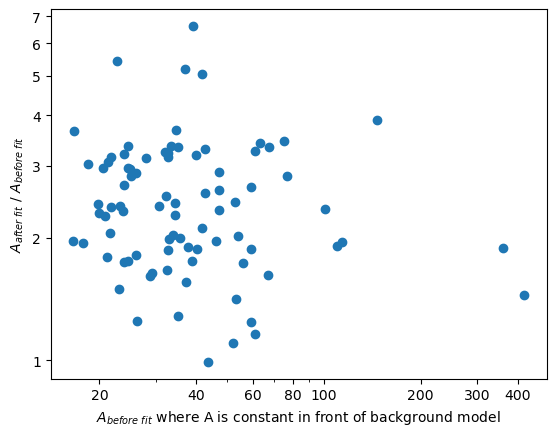

In [58]:
plt.scatter(ORIGA, SKOLKO)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$A_{before \ fit}$ where A is constant in front of background model")
plt.ylabel("$A_{after \ fit} \ / \ A_{before \ fit}$")
xgtr = np.append(np.linspace(20, 100, 5).astype(int), [200,300,400])
plt.xticks(xgtr, xgtr)
ygtr = [1,2,3,4,5,6,7]
plt.yticks(ygtr, ygtr)
plt.show()

#### Making the number of averaged $T / L / E_{av}$ without background the same:

In [182]:
table_name = '0_ab-fix_cstat_10ks_standard-'+str(NNNN)

read_table = pd.read_csv('tables/table_'+table_name+'.csv', header=None, index_col=0, delimiter=' ').to_dict()
    
temp_usr =  list(zip(read_table[1].values(), read_table[2].values(), read_table[3].values()))
lumin_usr = list(zip(read_table[4].values(), read_table[5].values(), read_table[6].values()))
aven_usr =  list(zip(read_table[7].values(), read_table[8].values()))

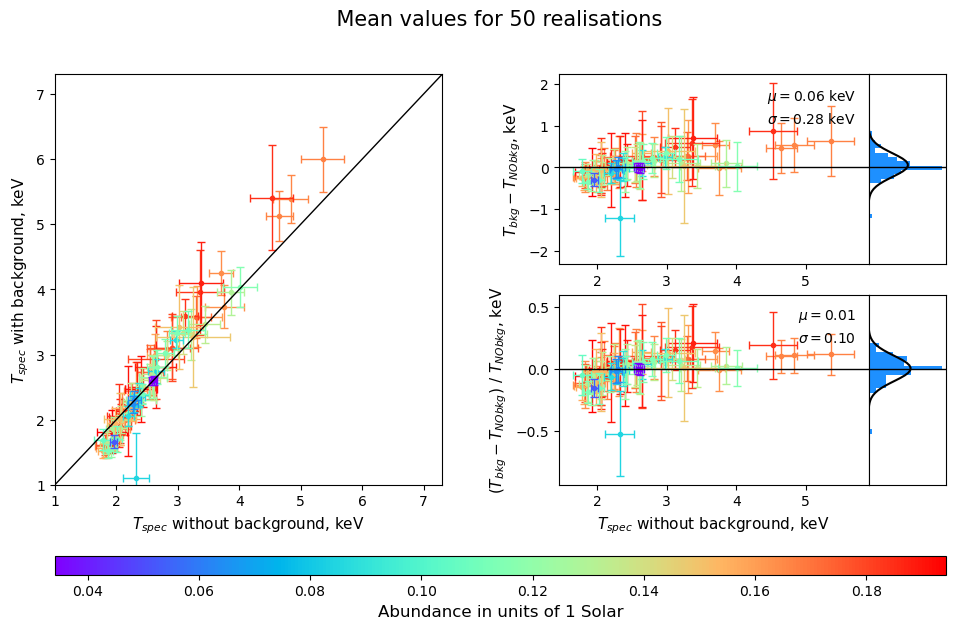

In [114]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

draw_three_panels(x_array=temp_usr, 
                  y_array=temp_usr_with_bkg,
                  x_label="$T_{spec}$ without background, keV",
                  y_label_left="$T_{spec}$ with background, keV",
                  y_label_right_up="$T_{bkg} - T_{NObkg}$, keV",
                  y_label_right_down="$(T_{bkg} - T_{NObkg}) \ / \ T_{NObkg}$, keV",
                  clr='dodgerblue',
                  NnNn = NNNN,
                  cmap=redshifts)

#plt.savefig('figures/T_with_bkg_vs_T_without_bkg.pdf', format='pdf')
plt.show()

#### How fitted temperature with added background varies depending on impact of AGNs in background?

In [ ]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

for AGN in [0.0, 0.25, 0.5, 0.75, 1.0]:

    NNNN = 1

    table_name = '5_BKG-'+str(NNNN)+'-AGN='+str(AGN)

    read_table = pd.read_csv('tables/table_'+table_name+'.csv', header=None, index_col=0, delimiter=' ').to_dict()

    temp_usr_with_bkg =  list(zip(read_table[1].values(), read_table[2].values(), read_table[3].values()))

    draw_three_panels(x_array=temp_usr, 
                      y_array=temp_usr_with_bkg,
                      x_label="$T_{spec}$ without background, keV",
                      y_label_left="$T_{spec}$ with background, keV",
                      y_label_right_up="$T_{bkg} - T_{NObkg}$, keV",
                      y_label_right_down="$(T_{bkg} - T_{NObkg}) \ / \ T_{NObkg}$, keV",
                      clr='dodgerblue',
                      NnNn = NNNN,
                      cmap_by_redshifts=True)
    
    plt.suptitle(f"    Mean values for {NNNN} realisations \n $const$ before AGN in model for background: {AGN}", fontsize=15)

    plt.savefig(str(AGN)+".png", format="png")
    plt.show()

### Comparing clear $T$ and $L$ from fitting (not simulations) and them with background added:

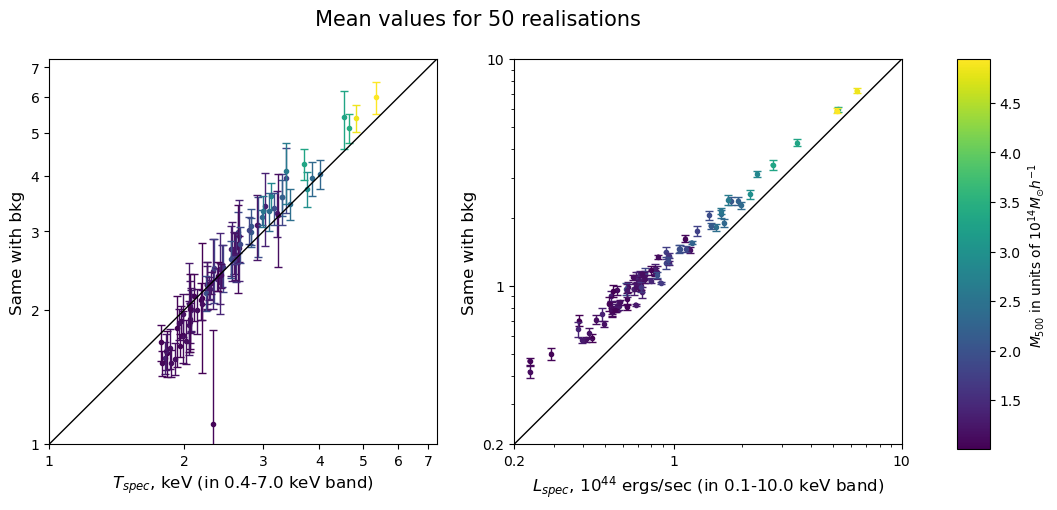

In [184]:
plt.figure(figsize=(11,5))

plt.suptitle(f"     Mean values for {NNNN} realisations", fontsize=15)

plt.subplot(121)

#xx = [a[0] for a in temp_usr_with_bkg]
xx = [a[1] for a in temp_usr]
yy = [a[1] for a in temp_usr_with_bkg]
y_err = [a[2] for a in temp_usr_with_bkg]

#plt.errorbar(xx, yy, yerr=[yerr_l, yerr_r], linewidth=0, elinewidth=1, color='b', marker='o', markersize=3)

for xxx, yyy, eee, col in zip(xx, yy, y_err, mass_colour):
    plt.plot(xxx, yyy, '.', color=col)
    plt.errorbar(xxx, yyy, yerr=eee, elinewidth=1, capsize=3, color=col)

#plt.xlabel("$T_{500}$, keV", fontsize=12)
plt.xlabel("$T_{spec}$, keV (in 0.4-7.0 keV band)", fontsize=12)
plt.ylabel("Same with bkg", fontsize=12)

plt.xlim(1., 7.3)
plt.ylim(1., 7.3)

plt.xscale("log")
plt.yscale("log")

plt.xticks([1,2,3,4,5,6,7], [1,2,3,4,5,6,7])
plt.yticks([1,2,3,4,5,6,7], [1,2,3,4,5,6,7])

plt.plot(plt.gca().get_xlim(), plt.gca().get_ylim(), color='black', linewidth=1)


plt.subplot(122)

#xx = [a[0] for a in lumin_usr_with_bkg]
xx = [a[1] for a in lumin_usr]
yy = [a[1] for a in lumin_usr_with_bkg]
y_err = [a[2] for a in lumin_usr_with_bkg]

#plt.errorbar(xx, yy, yerr=[yerr_l, yerr_r], linewidth=0, elinewidth=1, color='b', marker='o', markersize=3)

for xxx, yyy, eee, col in zip(xx, yy, y_err, mass_colour):
    plt.plot(xxx, yyy, '.', color=col)
    plt.errorbar(xxx, yyy, yerr=eee, elinewidth=1, capsize=3, color=col)

#plt.xlabel("$L_{x500}$, $10^{44}$ ergs/sec", fontsize=12)
plt.xlabel("$L_{spec}$, $10^{44}$ ergs/sec (in 0.1-10.0 keV band)", fontsize=12)
plt.ylabel("Same with bkg", fontsize=12)

plt.xscale("log")
plt.yscale("log")

plt.xlim(0.2, 10)
plt.ylim(0.2, 10)

plt.xticks([0.2, 1, 10], [0.2, 1, 10])
plt.yticks([0.2, 1, 10], [0.2, 1, 10])

plt.plot( plt.gca().get_xlim(), plt.gca().get_ylim(), color='black', linewidth=1)

plt.subplots_adjust(right=0.9)
sc = plt.scatter(xx, yy, c=masses, s=5)
clb = plt.colorbar(sc, cax = plt.axes([0.95, 0.1, 0.03, 0.78]), 
                   label = "$M_{500}$ in units of $10^{14} M_{\odot} h^{-1}$")

plt.savefig('figures/T_vs_T_and_L_vs_L_with_bkg.pdf', format='pdf')
plt.show()

### Average energy as a function of **mean** temperature with background added:

[0.05118404 0.2801801 ] [0.04158837 0.24229799]


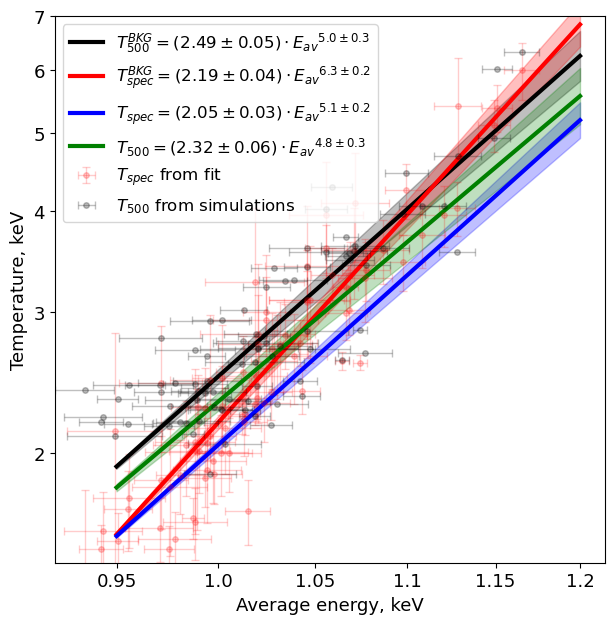

In [188]:
plt.figure(figsize=(7.1,7.1))

xx = [a[0] for a in aven_usr_with_bkg]
x_err = [a[1] for a in aven_usr_with_bkg]
yy1 = [a[0] for a in temp_usr_with_bkg]
yy2 = [a[1] for a in temp_usr_with_bkg]
y2_err = [a[2] for a in temp_usr_with_bkg]

def func(x, a, b):
    return a * x**b

with_intervals = True

if with_intervals:
    popt1, pcov1 = curve_fit(func, xx, yy1)
    popt2, pcov2 = curve_fit(func, xx, yy2)

    perr1 = np.sqrt(np.diagonal(pcov1))
    perr2 = np.sqrt(np.diagonal(pcov2))

    pp = (1. + 0.68)/2
    nstd = stats.norm.ppf(pp)
    
    print(nstd*perr1, nstd*perr2)

    popt1d = (popt1[0]-nstd*perr1[0], popt1[1]-nstd*perr1[1])
    popt1u = (popt1[0]+nstd*perr1[0], popt1[1]+nstd*perr1[1])
    
    popt2d = (popt2[0]-nstd*perr2[0], popt2[1]-nstd*perr2[1])
    popt2u = (popt2[0]+nstd*perr2[0], popt2[1]+nstd*perr2[1])

#for xxx, xe, yyy, ye, col in zip(xx, x_err, yy2, y2_err, mass_colour):
#   plt.plot(xxx, yyy, '.', color=col)
#    plt.errorbar(xxx, yyy, xerr=xe, yerr=ye, elinewidth=1, capsize=3, color=col, label='$T_{spec}$ from fit')

#list1, list2, list3 = zip(*sorted(zip(xx, [n-q for n, q in zip(yy2, y2_err)], [n+q for n, q in zip(yy2, y2_err)])))
#plt.fill_between(list1, list2, list3, interpolate=False, alpha=0.4, color='blue')

plt.errorbar(xx, yy2, xerr=x_err, yerr=y2_err, linewidth=0, marker='o', markersize=4, alpha=0.2,
             elinewidth=1, capsize=3, color='red', label='$T_{spec}$ from fit')

lll = np.linspace(0.95, 1.2, 100)
plt.plot(lll, [func(XX, *popt1) for XX in lll],  
         color='black', linewidth=3, linestyle='-', alpha=1,
         label=f'$T_{{500}}^{{BKG}} = ({popt1[0]:.2f} \pm {perr1[0]:.2f}) \cdot {{E_{{av}}}}^{{{popt1[1]:.1f} \pm {perr1[1]:.1f}}}$')
plt.plot(lll, [func(XX, *popt2) for XX in lll],  
         color='red', linewidth=3, linestyle='-', alpha=1,
         label=f'$T_{{spec}}^{{BKG}} = ({popt2[0]:.2f} \pm {perr2[0]:.2f}) \cdot {{E_{{av}}}}^{{{popt2[1]:.1f} \pm {perr2[1]:.1f}}}$')

if with_intervals:
    plt.fill_between(lll, 
                     [func(XX, *popt1u) for XX in lll], 
                     [func(XX, *popt1d) for XX in lll], 
                     interpolate=False, alpha=0.25, color='black')
    plt.fill_between(lll, 
                     [func(XX, *popt2u) for XX in lll], 
                     [func(XX, *popt2d) for XX in lll], 
                     interpolate=False, alpha=0.25, color='red')

plt.xlabel("Average energy, keV", fontsize=13)
plt.ylabel("Temperature, keV", fontsize=13)

plt.xscale("log")
plt.yscale("log")

#sc = plt.scatter(xx, yy1, c='red', s=0)
#clb = plt.colorbar(sc, label = "$M_{500}$ in units of $10^{14} M_{\odot} h^{-1}$")

#list1, list2, list3 = zip(*sorted(zip(yy1, [n-q for n, q in zip(xx, x_err)], [n+q for n, q in zip(xx, x_err)])))
#plt.gca().fill_betweenx(list1, list2, list3, interpolate=True, alpha=0.4, color='red')

plt.errorbar(xx, yy1, xerr=x_err, linewidth=0, elinewidth=1, capsize=3,
             color='black', marker='o', markersize=4, alpha=0.25, label='$T_{500}$ from simulations')

#plt.xlim(1.4, 7.5)
#plt.ylim(0.9, 1.3)

ddd=True

if ddd:
    plt.plot(lll, 2.05*lll**5.1,  
         color='blue', linewidth=3, linestyle='-', alpha=1,
         label=f'$T_{{spec}} = (2.05 \pm 0.03) \cdot {{E_{{av}}}}^{{5.1 \pm 0.2}}$')
    plt.fill_between(lll, 
                     2.02*lll**4.9, 
                     2.08*lll**5.3, 
                     interpolate=False, alpha=0.25, color='blue')
    
if ddd:
    plt.plot(lll, 2.32*lll**4.8,  
         color='green', linewidth=3, linestyle='-', alpha=1,
         label=f'$T_{{500}} = (2.32 \pm 0.06) \cdot {{E_{{av}}}}^{{4.8 \pm 0.3}}$')
    plt.fill_between(lll, 
                     2.26*lll**4.5, 
                     2.38*lll**5.1, 
                     interpolate=False, alpha=0.25, color='green')  
    

plt.xticks([0.95, 1.00, 1.05, 1.10, 1.15, 1.2], [0.95, 1.00, 1.05, 1.10, 1.15, 1.2], size=13)
plt.yticks([2,3,4,5,6,7], [2,3,4,5,6,7], size=13)

#for i in range(0, len(aven_usr)):
#    plt.plot([xx[i]+0.000454, xx[i]+0.000454], 
#             [yy1[i], yy2[i]], 
#             color='grey', alpha=0.5, marker='o', markersize=4)

#plt.grid()
plt.legend(loc=2, fontsize=12)

plt.xlim(ooofff[0])
plt.ylim(ooofff[1])

if not ddd:
    plt.savefig('figures/T_vs_Eav_with_bkg.pdf', format='pdf')
else:
    plt.savefig('figures/T_vs_Eav_with_bkg_ext.pdf', format='pdf')

plt.show()

## (H) Temperature vs. mass

[0.05143596 0.0297688 ] [0.10426239 0.06751063] [0.10426239 0.06751063]


<Figure size 640x480 with 0 Axes>

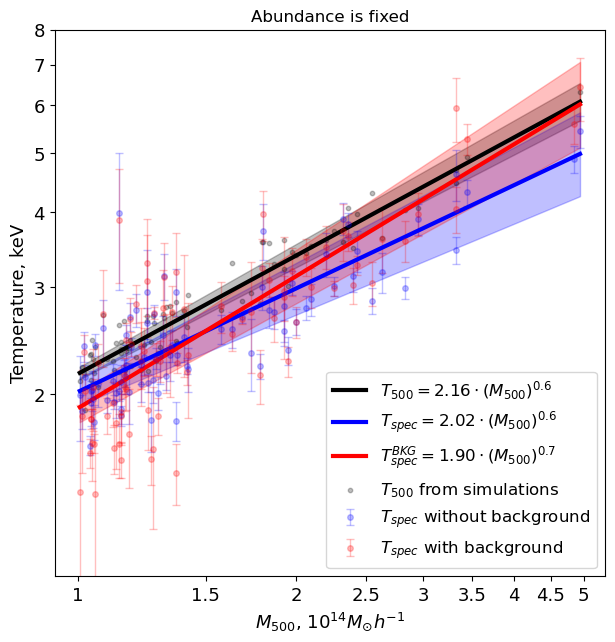

In [59]:
%run -i 'utils/functions.py'

plt.figure(figsize=(7.1,7.1))

MASSES = [m/10**14 for m in clusters["M500"].values] # or just "masses" defined before
T500S = clusters["T500"].values
yyyy1 = [a[1] for a in temp_usr]
yyyy1_err = [a[2] for a in temp_usr]
yyyy2 = [a[1] for a in temp_usr_with_bkg]
yyyy2_err = [a[2] for a in temp_usr_with_bkg]

#print(clusters["z_true"].values)

MASSES = MASSES#*E(clusters["z_true"].values)

def func(x, a, b):
    return a * x**b

if with_intervals:
    popt1, pcov1 = curve_fit(func, MASSES, T500S)
    popt2, pcov2 = curve_fit(func, MASSES, yyyy1)
    popt3, pcov3 = curve_fit(func, MASSES, yyyy2)

    perr1 = np.sqrt(np.diagonal(pcov1))
    perr2 = np.sqrt(np.diagonal(pcov2))
    perr3 = np.sqrt(np.diagonal(pcov2))

    pp = (1. + 0.95)/2
    nstd = stats.norm.ppf(pp)
    
    print(nstd*perr1, nstd*perr2, nstd*perr3)

    popt1d = (popt1[0]-nstd*perr1[0], popt1[1]-nstd*perr1[1])
    popt1u = (popt1[0]+nstd*perr1[0], popt1[1]+nstd*perr1[1])
    
    popt2d = (popt2[0]-nstd*perr2[0], popt2[1]-nstd*perr2[1])
    popt2u = (popt2[0]+nstd*perr2[0], popt2[1]+nstd*perr2[1])
    
    popt3d = (popt3[0]-nstd*perr3[0], popt3[1]-nstd*perr3[1])
    popt3u = (popt3[0]+nstd*perr3[0], popt3[1]+nstd*perr3[1])

#list1, list2, list3 = zip(*sorted(zip(MASSES, [n-q for n, q in zip(yyyy1, yyyy1_err)], [n+q for n, q in zip(yyyy1, yyyy1_err)])))
#plt.fill_between(list1, list2, list3, interpolate=False, alpha=0.4, color='blue')

plt.errorbar(MASSES, yyyy1, yerr=yyyy1_err, linewidth=0, marker='o', markersize=4, alpha=0.25,
             elinewidth=1, capsize=3, color='blue', label='$T_{spec}$ without background')

#list1, list2, list3 = zip(*sorted(zip(MASSES, [n-q for n, q in zip(yyyy2, yyyy2_err)], [n+q for n, q in zip(yyyy2, yyyy2_err)])))
#plt.fill_between(list1, list2, list3, interpolate=True, alpha=0.4, color='red')

plt.errorbar(MASSES, yyyy2, yerr=yyyy2_err, linewidth=0, marker='o', markersize=4, alpha=0.25,
             elinewidth=1, capsize=3, color='red', label='$T_{spec}$ with background')

lll = np.linspace(min(MASSES), max(MASSES), 100)
plt.plot(lll, [func(XX, *popt1) for XX in lll],  
         color='black', linewidth=3, linestyle='-', alpha=1,
         label=f'$T_{{500}} = {popt1[0]:.2f} \cdot ({{M_{{500}}}})^{{{popt1[1]:.1f}}}$')

plt.plot(lll, [func(XX, *popt2) for XX in lll],  
         color='blue', linewidth=3, linestyle='-', alpha=1,
         label=f'$T_{{spec}} = {popt2[0]:.2f} \cdot ({{M_{{500}}}})^{{{popt2[1]:.1f}}}$')

plt.plot(lll, [func(XX, *popt3) for XX in lll],  
         color='red', linewidth=3, linestyle='-', alpha=1,
         label=f'$T_{{spec}}^{{BKG}} = {popt3[0]:.2f} \cdot ({{M_{{500}}}})^{{{popt3[1]:.1f}}}$')

if with_intervals:
    plt.fill_between(lll, 
                     [func(XX, *popt1u) for XX in lll], 
                     [func(XX, *popt1d) for XX in lll], 
                     interpolate=False, alpha=0.25, color='black')
    plt.fill_between(lll, 
                     [func(XX, *popt2u) for XX in lll], 
                     [func(XX, *popt2d) for XX in lll], 
                     interpolate=False, alpha=0.25, color='blue')
    plt.fill_between(lll, 
                     [func(XX, *popt3u) for XX in lll], 
                     [func(XX, *popt3d) for XX in lll], 
                     interpolate=False, alpha=0.25, color='red')

plt.scatter(MASSES, T500S, color='black', label='$T_{500}$ from simulations', marker='o', s=10, alpha=0.25)

plt.xlabel("$M_{500}$, $10^{14} M_{\odot} h^{-1}$", fontsize=13)
plt.ylabel("Temperature, keV", fontsize=13)

plt.xscale("log")
plt.yscale("log")

#plt.xlim(1.4, 7.5)
plt.ylim(1., 8)

plt.xticks([1,1.5,2,2.5,3,3.5,4,4.5,5], [1,1.5,2,2.5,3,3.5,4,4.5,5], size=13)
plt.yticks([2,3,4,5,6,7,8], [2,3,4,5,6,7,8], size=13)

#for i in range(0, len(aven_usr)):
#    plt.plot([xx[i]+0.000454, xx[i]+0.000454], 
#             [yy1[i], yy2[i]], 
#             color='grey', alpha=0.5, marker='o', markersize=4)

#plt.grid()
plt.legend(loc=4, fontsize=12)
#plt.savefig('figures/T_vs_M.pdf', format='pdf')
plt.show()

## (I) Average energy vs. mass

0.28744928196813674
0.6666666666666666 0.3333333333333333 84


<Figure size 640x480 with 0 Axes>

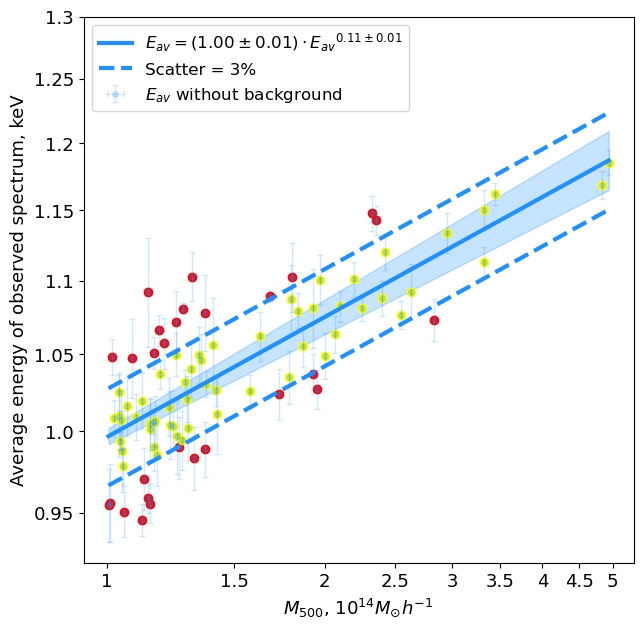

In [161]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

plt.figure(figsize=(7.1,7.1))

MASSES = [m/10**14 for m in clusters["M500"].values] # or just "masses" defined before

yyyy1 = [a[0] for a in aven_usr]
yyyy1_err = [a[1] for a in aven_usr]
yyyy2 = [a[0] for a in aven_usr_with_bkg]
yyyy2_err = [a[1] for a in aven_usr_with_bkg]

def func(x, a, b):
    return a * x**b

def inv_func(y, a, b):
    return (y/a)**(1/b)

lll = np.linspace(min(MASSES), max(MASSES), 100)
    
draw_line(MASSES, np.zeros(len(MASSES)), yyyy1, yyyy1_err, 
          clr = 'dodgerblue', 
          l4dots = '$E_{av}$ without background', 
          l4legend = 'E_{{av}}',
          with_scatter=True,
          u4et_oshibok=False)

#draw_line(MASSES, np.zeros(len(MASSES)), yyyy2, yyyy2_err, 
#          clr = 'orangered', 
#          l4dots = '$E_{av}$ with background', 
#          l4legend = 'E_{{av}}^{{BKG}}',
#          with_scatter=False,
#          u4et_oshibok=False)    

plt.xlabel("$M_{500}$, $10^{14} M_{\odot} h^{-1}$", fontsize=13)
plt.ylabel("Average energy of observed spectrum, keV", fontsize=13)

plt.xscale("log")
plt.yscale("log")

#plt.xlim(1.4, 7.5)
#plt.ylim(0.9, 1.3)

plt.xticks([1,1.5,2,2.5,3,3.5,4,4.5,5], [1,1.5,2,2.5,3,3.5,4,4.5,5], size=13)
plt.yticks([0.95, 1.00, 1.05, 1.10, 1.15, 1.2, 1.25, 1.3], [0.95, 1.00, 1.05, 1.10, 1.15, 1.2, 1.25, 1.3], size=13)


plt.legend(loc=2, fontsize=12)

#plt.savefig('figures/Eav_vs_M.pdf', format='pdf')
plt.show()

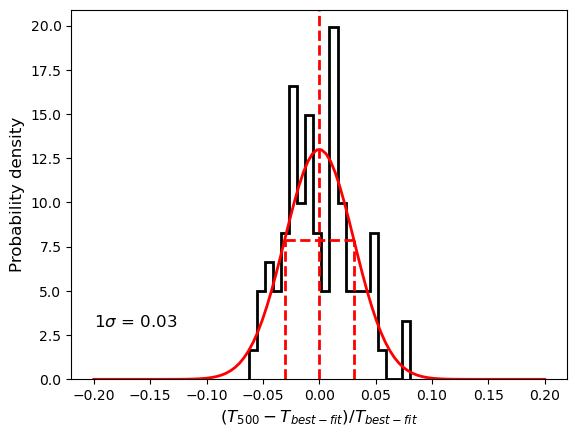

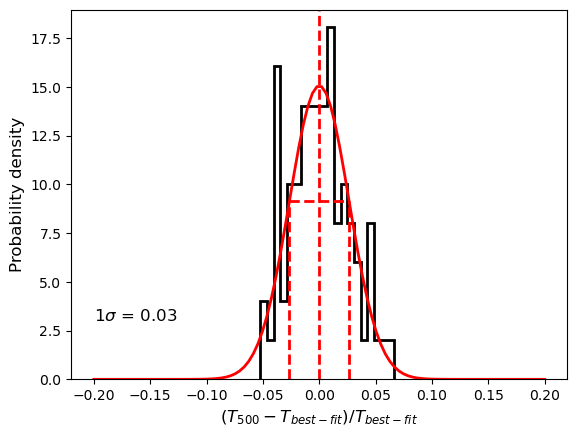

0.02648718967312399

In [155]:
%run -i 'utils/scripts.py'
%run -i 'utils/draw.py'

calculate_scatter(MASSES, yyyy1, plot=True)
calculate_scatter(MASSES, yyyy2, plot=True)

## (J) How much realisations are enough?

https://en.wikipedia.org/wiki/Unbiased_estimation_of_standard_deviation

https://en.wikipedia.org/wiki/Bias_of_an_estimator

https://en.wikipedia.org/wiki/Bessel%27s_correction

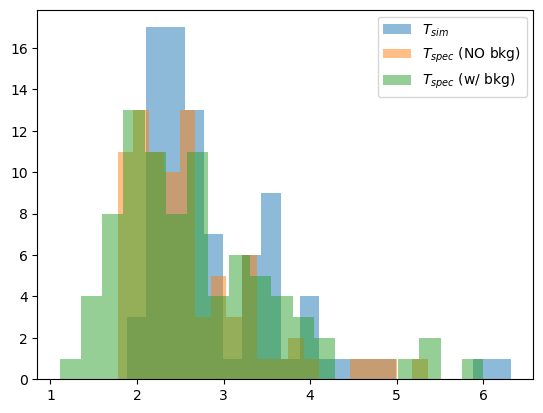

In [125]:
plt.hist([a[0] for a in temp_usr], bins=20, alpha=0.5, label="$T_{sim}$")
plt.hist([a[1] for a in temp_usr], bins=20, alpha=0.5, label="$T_{spec}$ (NO bkg)")
#plt.hist([a[0] for a in temp_usr_with_bkg], bins=20, alpha=0.5, label="$T_{sim}$")
plt.hist([a[1] for a in temp_usr_with_bkg], bins=20, alpha=0.5, label="$T_{spec}$ (w/ bkg)")
plt.legend()
plt.show()

#### Lets check how the moments of our distribution depend on number of realisations:

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

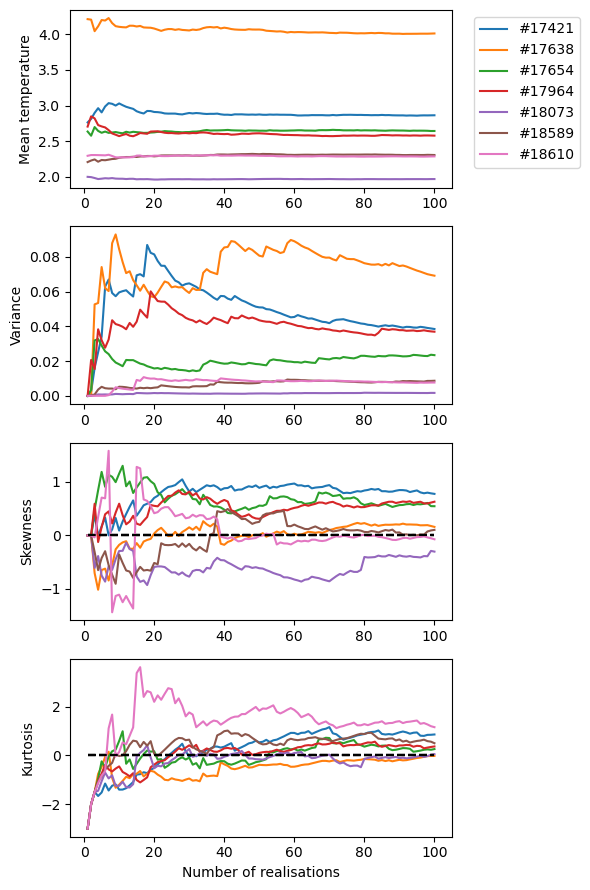

In [8]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6,9))

N_realisations = 100

#CL_NUMBER = clusters.index[:][-1]

for CL_NUMBER in tqdm(clusters.index[-10:-3]):

    cl_red = clusters.loc[CL_NUMBER]["z_true"]
    cl_T500 = clusters.loc[CL_NUMBER]["T500"]
    cl_lum = clusters.loc[CL_NUMBER]["Lx500"]

    temps = []      # увеличивающийся со временем массив со всеми температурами
    
    means = [] # массив со средними для данного набора
    variances = []    # массив со стандартными отклонениями для каждого отдельного набора температур
    skewnesses = []
    kurtosises = []
    

    for i in tqdm(range(1, N_realisations+1), leave=False):
        
        Ts = create_spectrum_and_fit_it(CL_NUMBER, borders=[0.4, 7.0], BACKGROUND=False, inside_radius="R500",
                                    Xplot=False, plot=False)

        temps.append(Ts[0][0])
        #print(temps)

        mean = np.mean(temps)
        variance = np.var(temps)
        skewness = stats.skew(temps)
        kurtosis = stats.kurtosis(temps, fisher=True)
        #print(np.sum(temps)/i)    

        # If True, Fisher’s definition is used (normal ==> 0.0).
        # If False, Pearson’s definition is used (normal ==> 3.0).

        means.append(mean)
        variances.append(variance)
        skewnesses.append(skewness)
        kurtosises.append(kurtosis) #True
        
        #print(i, end="")
        
    plt.subplot(4,1,1)
    plt.plot(np.linspace(1,i,i), means, label='#'+str(CL_NUMBER))
    #plt.xlabel("Number of realisations")
    plt.ylabel("Mean temperature")
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    
    plt.subplot(4,1,2)
    plt.plot(np.linspace(1,i,i), variances, label='#'+str(CL_NUMBER))
    #plt.xlabel("Number of realisations")
    plt.ylabel("Variance")
    #plt.legend()
    
    plt.subplot(4,1,3)
    plt.plot(np.linspace(1,i,i), skewnesses, label='#'+str(CL_NUMBER))
    plt.plot(np.linspace(1,i,i), np.zeros(i), linestyle = '--', color='black') 
    #plt.xlabel("Number of realisations")
    plt.ylabel("Skewness")
    #plt.legend()
    
    plt.subplot(4,1,4)
    plt.plot(np.linspace(1,i,i), kurtosises, label='#'+str(CL_NUMBER))
    plt.plot(np.linspace(1,i,i), np.zeros(i), linestyle = '--', color='black')
    # [m**3+3*m*v for m, v in zip(means, variances)]
    plt.xlabel("Number of realisations")
    plt.ylabel("Kurtosis")
    #plt.legend()
    
    plt.subplots_adjust()
    plt.tight_layout()

    
plt.savefig("figures/check_if_norm.pdf", format="pdf")
plt.show()

#### Pictures for histogram.gif

In [ ]:
%run -i 'utils/scripts.py'

N_realisations = 100

#CL_NUMBER = clusters.index[:][-1]

for CL_NUMBER in clusters.index[-5:-4]:

    cl_red = clusters.loc[CL_NUMBER]["z_true"]
    cl_T500 = clusters.loc[CL_NUMBER]["T500"]
    cl_lum = clusters.loc[CL_NUMBER]["Lx500"]

    temps = []      # увеличивающийся со временем массив со всеми температурами
    
    means = [] # массив со средними для данного набора
    variances = []    # массив со стандартными отклонениями для каждого отдельного набора температур
    skewnesses = []
    kurtosises = []
    
    Ts = create_spectrum_and_fit_it(CL_NUMBER, borders=[0.4, 7.0], BACKGROUND=False, inside_radius="R500",
                                    Xplot=False, plot=False, draw_only=False, draw_and_save_atable_model=False)

    temps.append(Ts[0][0])

    for i in range(2, N_realisations+1):
        
        Ts = create_spectrum_and_fit_it(CL_NUMBER, borders=[0.4, 7.0], BACKGROUND=False, inside_radius="R500",
                                    Xplot=False, plot=False, draw_only=False, draw_and_save_atable_model=False)

        temps.append(Ts[0][0])

        mean = np.mean(temps)
        stddev = np.std(temps)
        
        temps_norm = [(t-mean)/stddev for t in temps]
        
        plt.figure(figsize=(5,5))

        bars, bins = np.histogram(temps_norm)
        
        w = np.ones(len(temps_norm))#/len(temps_norm)
        
        plt.hist(temps_norm, weights = (1/np.sqrt(2*np.pi))*w/max(bars), color='#8c564b')
        
        xxxccc = np.linspace(-3,3,100)
        plt.plot(xxxccc, stats.norm.pdf(xxxccc), color='black', label="N(0,1)")
        
        plt.ylim(0, 0.44)
        
        plt.title("#"+str(CL_NUMBER)+": N="+str(i))
        plt.legend(loc="upper right")
        plt.xlabel("$(T_{spec} - T_{mean}) / \sigma$", fontsize=12)
    
        plt.savefig("../norm_dist/"+str(i)+".png", format="png")
        
        #plt.show()
        plt.clf()